# MSA 2023 Phase 2 - Part 1

In [44]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Classification Model

## 1. Find all variables and understand them

In [45]:
# Load dataset
market_segmentation = pd.read_csv("../0. Resources/datasets/market_segmentation.csv")

# Display first 10 instances of the dataset
market_segmentation.head(10)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


In [46]:
# Get column types and count of non-null values in each column
market_segmentation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [47]:
# Display summary statistics of numeric variables
market_segmentation.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [48]:
# Count unique values in each column
market_segmentation.nunique()

ID                 8068
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Var_1                 7
Segmentation          4
dtype: int64

## 2. Visualise the data

### Segmentation

<Axes: xlabel='Segmentation', ylabel='count'>

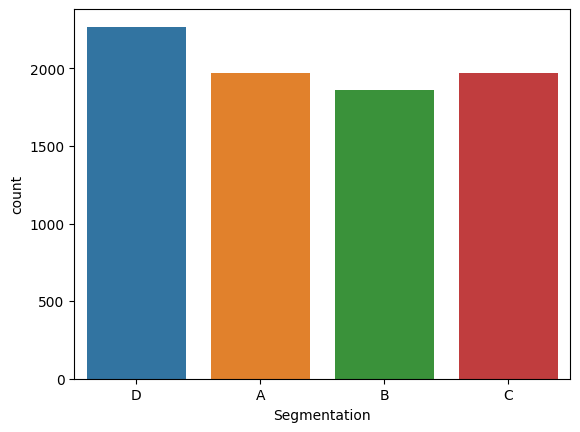

In [49]:
# Plot count of each segmentation class
sns.countplot(data=market_segmentation, x="Segmentation")

In [50]:
market_segmentation.Segmentation.value_counts()

Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64

In [51]:
market_segmentation = market_segmentation.groupby("Segmentation").apply(lambda x: x.sample(1858)).reset_index(drop=True)
market_segmentation.Segmentation.value_counts()

Segmentation
A    1858
B    1858
C    1858
D    1858
Name: count, dtype: int64

Classes are unbalanced. To fix this, we sampled the other classes to have the same count as the smallest class.

In [52]:
# Function to plot stacked bar charts
def plot_stacked_bar_charts(data, category, target="Segmentation"):
    # Calculate the frequency and proportion
    freq = data.groupby([category, target]).count().ID.unstack(target)
    prop = freq.divide(freq.sum(axis=1), axis=0)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(ncols=2)

    # Plot the frequency and proportion
    freq.plot(kind="bar", stacked=True, ax=ax1)
    prop.plot(kind="bar", stacked=True, ax=ax2)

    # Set axis labels
    ax1.set_ylabel("Frequency")
    ax2.set_ylabel("Proportion")

    # Set figure size
    fig.set_size_inches(12, 5)

### Age

<Axes: xlabel='Age', ylabel='Segmentation'>

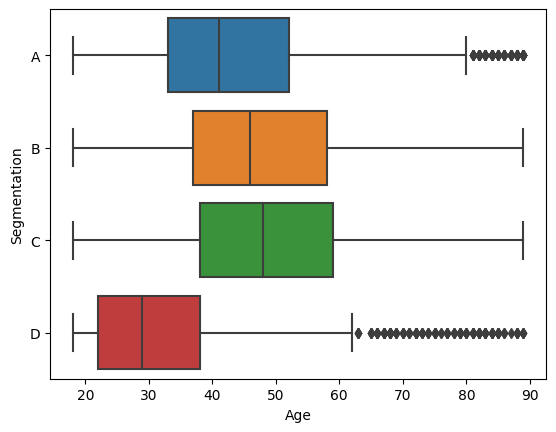

In [53]:
# Plot box plots of age for each segmentation class
sns.boxplot(market_segmentation, x="Age", y="Segmentation")

People in Segmentation D tend to have lower ages, followed by Segmentation A, then Segmentation B, then Segmentation C.

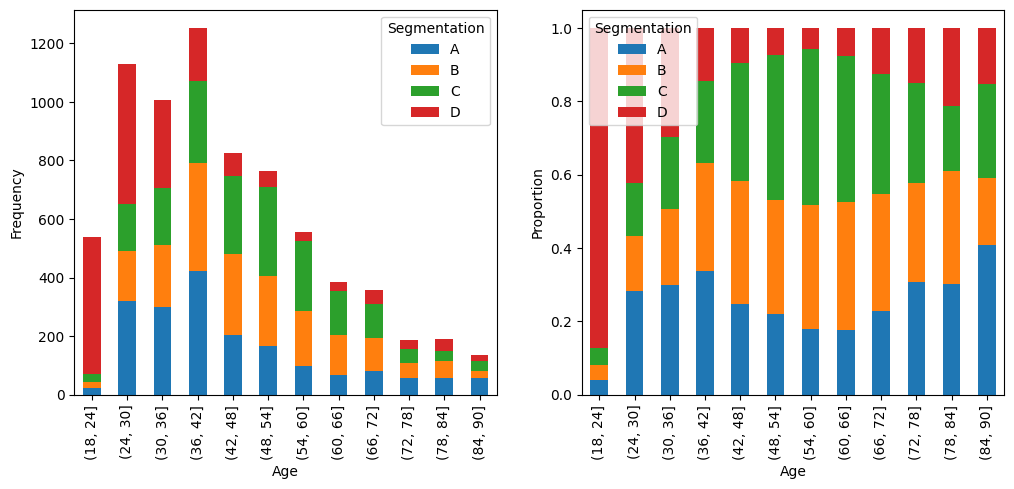

In [54]:
# Bin ages into six-year gaps
binned_ages = market_segmentation.copy()
binned_ages.Age = pd.cut(market_segmentation.Age, bins=np.arange(18, 96, 6))

# Plot stacked bar charts of age coloured by segmentation
plot_stacked_bar_charts(binned_ages, "Age")

The ages are right skewed in the database, with younger ages being more highly concentrated.

- The proportion of Segmentation A increases from ages 18 to 42, then decreases from ages 42 to 60, then increases from ages 66 to 90.
- The proportion of Segmentation B increases from ages 18 to 60, then decreases from ages 60 to 90.
- The proportion of Segmentation C increases from ages 18 to 60, then decreases from ages 60 to 90.
- The proportion of Segmentation D increases from ages 18 to 60, then decreases from ages 60 to 90.

Thus, there is a nonlinear relationship between the age and likelihood of being in each segmentation. We notice different patterns in different age segments. Therefore, we engineer a new feature of the age segmentation that can interact with how the age affects the probability of being classified into each segmentation.

### Work Experience

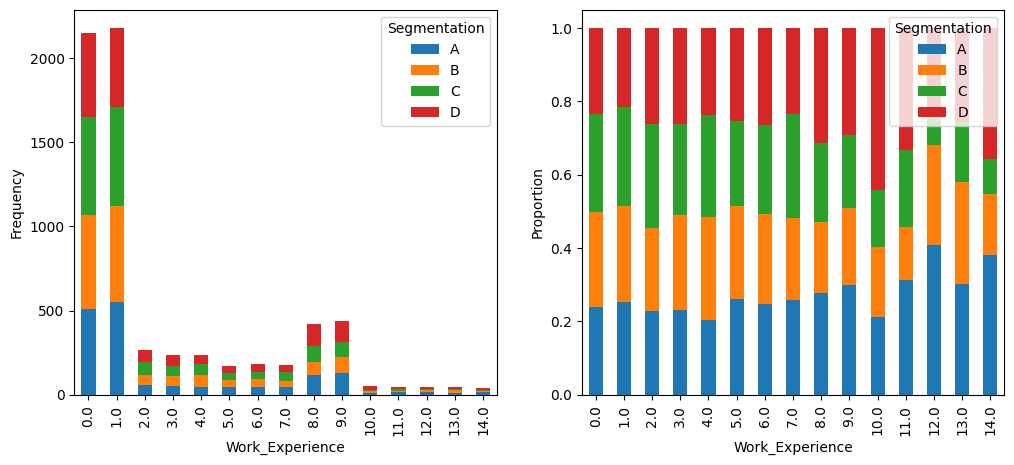

In [55]:
# Plot stacked bar charts of work experience coloured by segmentation
plot_stacked_bar_charts(market_segmentation, "Work_Experience")

There appear to be two large peaks at 0 and 1 and two smaller smaller peaks at 8 and 9. The distribution appears unrealistic with no explanation to the strange shape, which could mean there are errors in the data. Work experience also appears to have little effect on segmentation. In addition, many instances in the dataset are missing value for work experience. Therefore, we decided to drop this feature from the dataset.

### Family Size

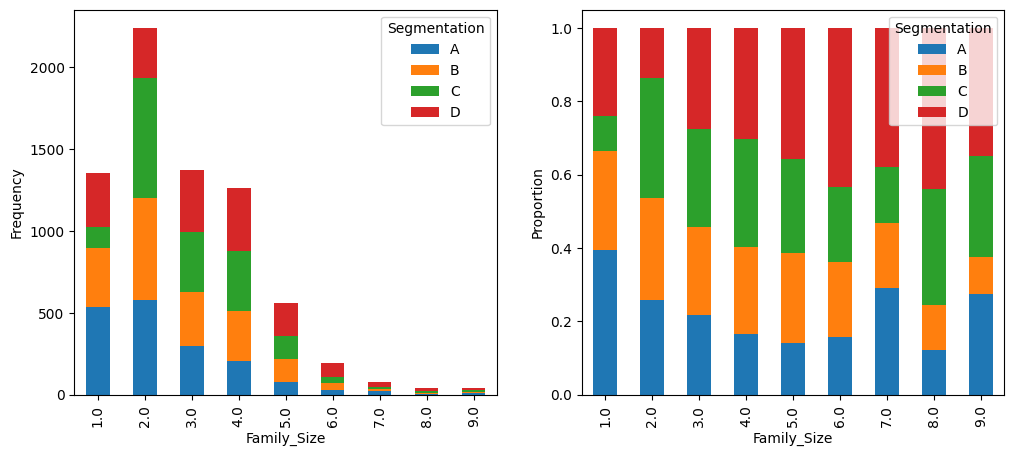

In [56]:
plot_stacked_bar_charts(market_segmentation, "Family_Size")

Family sizes are right skewed, with smaller family sizes more concentrated. There are fewer large family sizes, leading to greater variances in the proportion for greater family sizes.

- The proportion of Segmentation A appears to decrease with increasing family size.
- The proportion of Segmentation B appears to decrease with increasing family size.
- The proportion of Segmentation C appears to decrease with increasing family size.
- The proportion of Segmentation D appears to increase with increasing family size.

### Gender

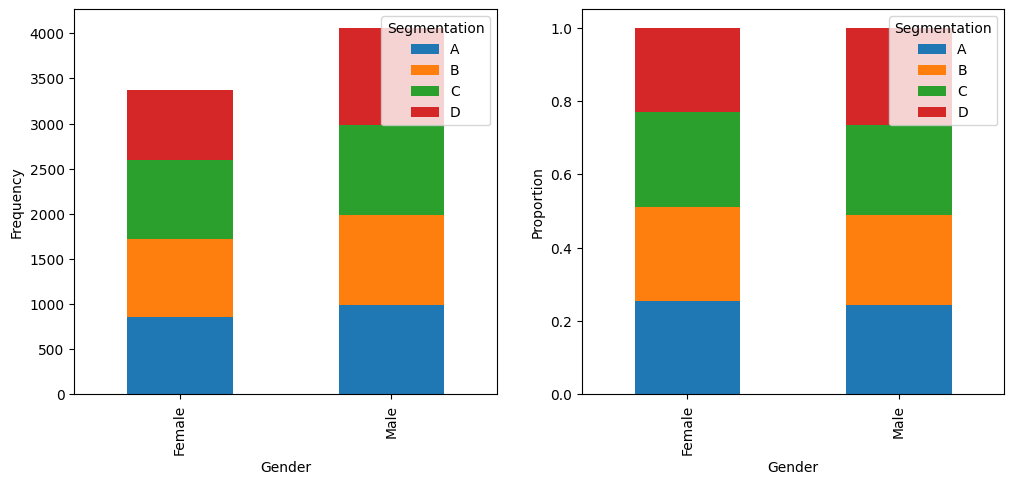

In [57]:
plot_stacked_bar_charts(market_segmentation, "Gender")

Gender does not appear to have a significant effect on the segmentation. Therefore, we drop the feature.

### Graduated

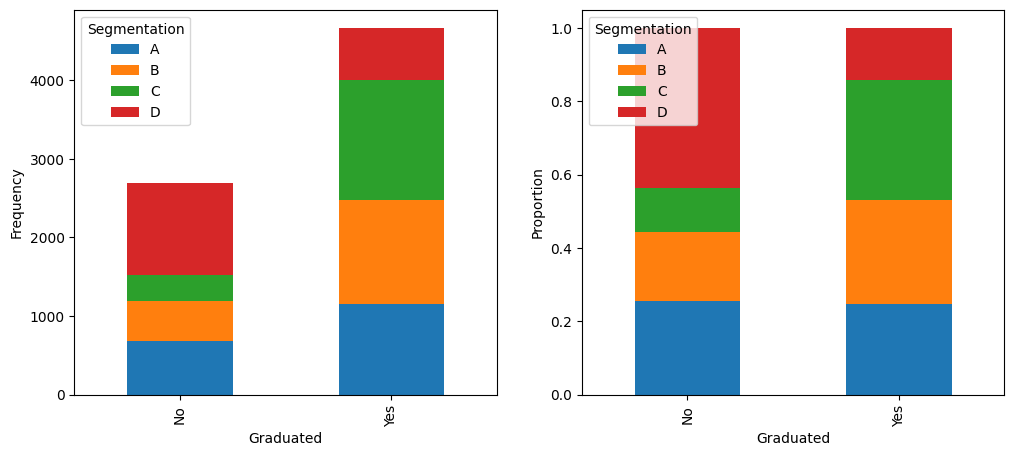

In [58]:
plot_stacked_bar_charts(market_segmentation, "Graduated")

Graduated individuals are less likely to be in Segmentation D, more likely to be in Segmentation B, and more likely to be in Segmentation C than non-graduated individuals. The proportion in Segmentation A does not appear to differe between graduated and non-graduated individuals.

### Ever Married

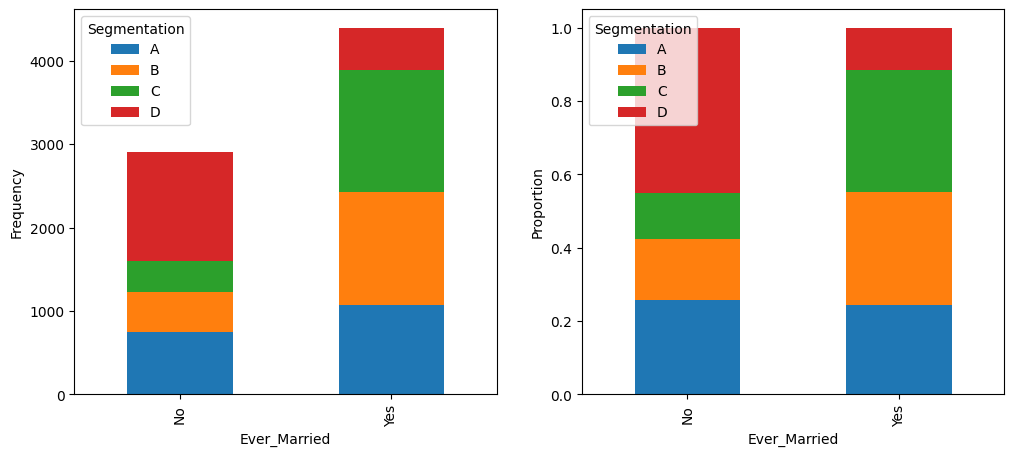

In [59]:
plot_stacked_bar_charts(market_segmentation, "Ever_Married")

Indivudals who have married are more likely to be in Segmentation B, more likely to be in Segmentation C and less likely to be in segmentation D than individuals who have not married. The proportion in Segmentation A does not appear to differ between those who have married and those who haven't.

### Spending Score

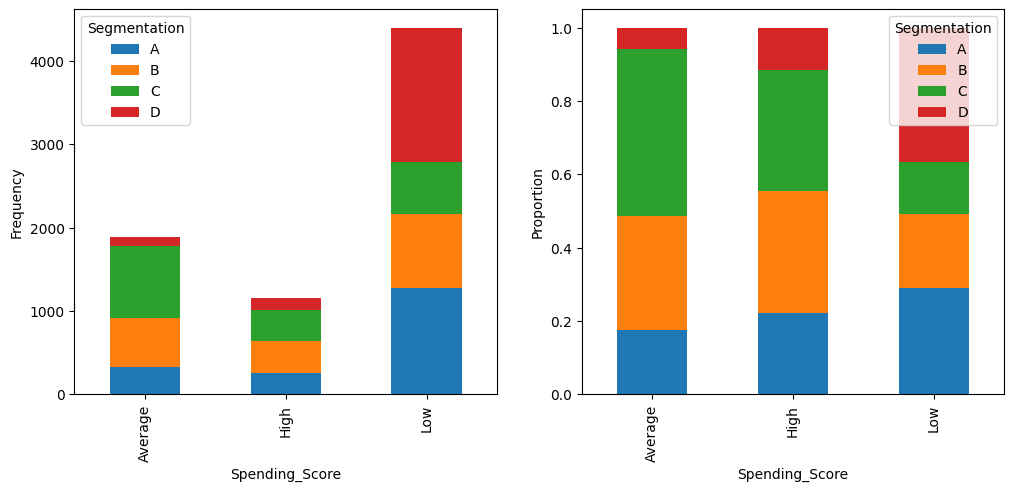

In [60]:
plot_stacked_bar_charts(market_segmentation, "Spending_Score")

Spending score appears to affect the segmentation.

- The proportion of Segmentation A is lowest for average, then high, then low spending scores.
- The proportion of Segmentation B is lowest for low, then about the same for average and high spending scores.
- The proportion of Segmentation C is lowest for low, then high, then average spending scores.
- The proportion of Segmentation D is lowest for average, then high, then low spending scores.

Even though the spending score category appears to be an ordered category, from the trends we observe it may be more effect to use one-hot encoding on this feature.

### Profession

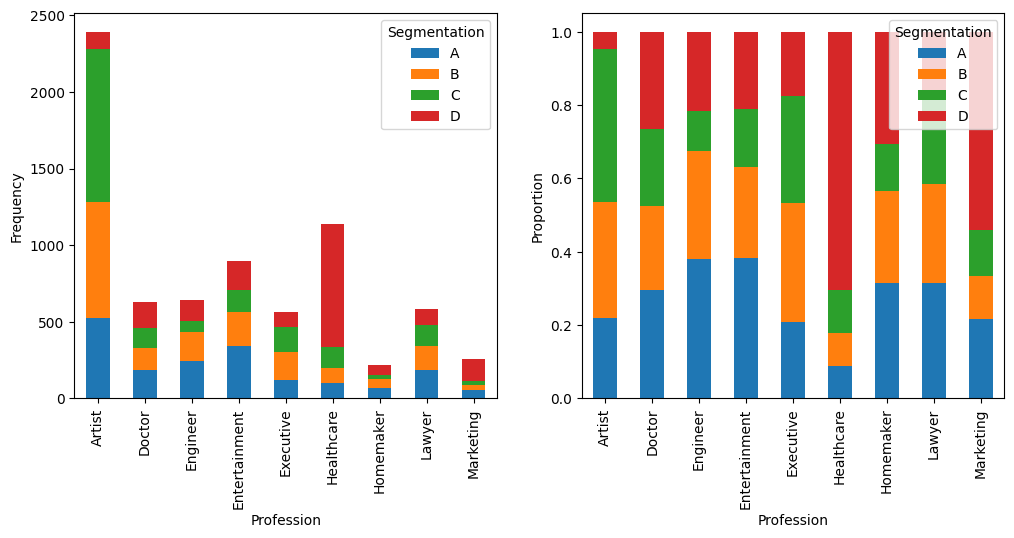

In [61]:
plot_stacked_bar_charts(market_segmentation, "Profession")

Profession appears to affect the segmentation.

### Var_1

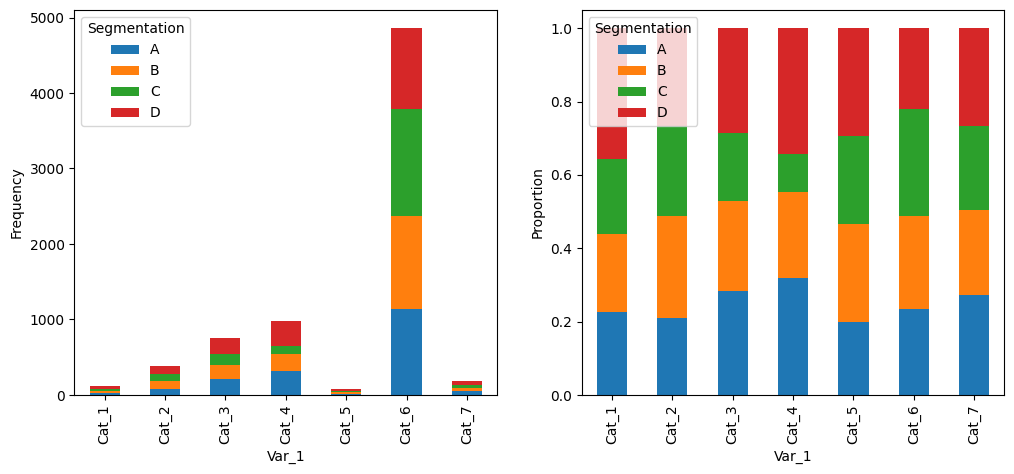

In [62]:
plot_stacked_bar_charts(market_segmentation, "Var_1")

Most of the instances have a value of Cat_6 for Var_1. Var_1 appears to have no significant effect on the segmentation. In addition, the meaning of the variable is unclear. Therefore, we drop the feature.

## 3. Clean data

In [63]:
# Drop unnecessary features
market_segmentation.drop(columns=["ID", "Gender", "Work_Experience", "Var_1"], inplace=True)

In [64]:
# Fill missing family size values with median
market_segmentation.Family_Size.fillna(market_segmentation.Family_Size.median(), inplace=True)

# Drop rows with missing value for graduated and ever married
market_segmentation.dropna(subset=["Graduated", "Ever_Married"], inplace=True)

In [65]:
# Convert variables with two categories into binary numeric variables
market_segmentation = pd.get_dummies(market_segmentation, columns=["Graduated", "Ever_Married"], drop_first=True, dtype=int)

In [67]:
# Apply one-hot encoding on variables with 3+ categories
market_segmentation = pd.get_dummies(market_segmentation, columns=["Spending_Score", "Profession"], dtype=int)

In [69]:
# Create age segment feature which splits the ages into Adult (18-41), Middle Aged (42-59) and Elderly (60+)
market_segmentation_interaction = market_segmentation.copy()
market_segmentation_interaction["Age_Segment"] = np.where(
    market_segmentation.Age < 42, "Adult", np.where(
        market_segmentation.Age < 60, "Middle_Aged", "Elderly"
    )
)
market_segmentation_interaction = pd.get_dummies(market_segmentation_interaction, columns=["Age_Segment"], dtype=int)

In [70]:
# Normalise numeric variables
scaler = MinMaxScaler()
market_segmentation[["Age", "Family_Size"]] = scaler.fit_transform(market_segmentation[["Age", "Family_Size"]])
market_segmentation_interaction[["Age", "Family_Size"]] = scaler.fit_transform(market_segmentation_interaction[["Age", "Family_Size"]])

In [71]:
# Add interaction terms between age segment and age
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
market_segmentation_interaction["Age_Adult"] = poly.fit_transform(market_segmentation_interaction[["Age_Segment_Adult", "Age"]])[:,2]
market_segmentation_interaction["Age_Middle_Aged"] = poly.fit_transform(market_segmentation_interaction[["Age_Segment_Middle_Aged", "Age"]])[:,2]
market_segmentation_interaction["Age_Elderly"] = poly.fit_transform(market_segmentation_interaction[["Age_Segment_Elderly", "Age"]])[:,2]

In [72]:
market_segmentation.head()

,Age,Family_Size,Segmentation,Graduated_Yes,Ever_Married_Yes,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,0.521127,0.000,A,1,0,0,0,1,0,0,0,1,0,0,0,0,0
1,0.450704,0.000,A,1,1,0,0,1,1,0,0,0,0,0,0,0,0
2,0.281690,0.250,A,1,0,0,0,1,0,0,0,1,0,0,0,0,0
3,1.000000,0.000,A,0,1,0,0,1,0,0,0,0,0,0,0,1,0
4,0.267606,0.375,A,1,0,0,0,1,1,0,0,0,0,0,0,0,0


In [73]:
market_segmentation_interaction.head()

,Age,Family_Size,Segmentation,Graduated_Yes,Ever_Married_Yes,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Profession_Artist,Profession_Doctor,...,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Age_Segment_Adult,Age_Segment_Elderly,Age_Segment_Middle_Aged,Age_Adult,Age_Middle_Aged,Age_Elderly
0,0.521127,0.000,A,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0.000000,0.521127,0.0
1,0.450704,0.000,A,1,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0.000000,0.450704,0.0
2,0.281690,0.250,A,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0.281690,0.000000,0.0
3,1.000000,0.000,A,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0.000000,0.000000,1.0
4,0.267606,0.375,A,1,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0.267606,0.000000,0.0


## 4. Identify correlated variables

<Axes: >

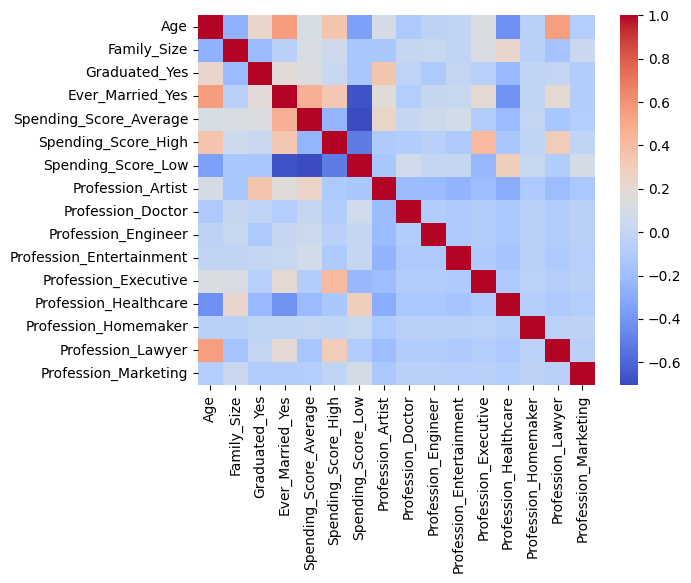

In [74]:
# Compute the correlation matrix
correlation = market_segmentation.drop(columns=["Segmentation"]).corr()

# Display the correlation on a heatmap
sns.heatmap(correlation, cmap='coolwarm')

<Axes: >

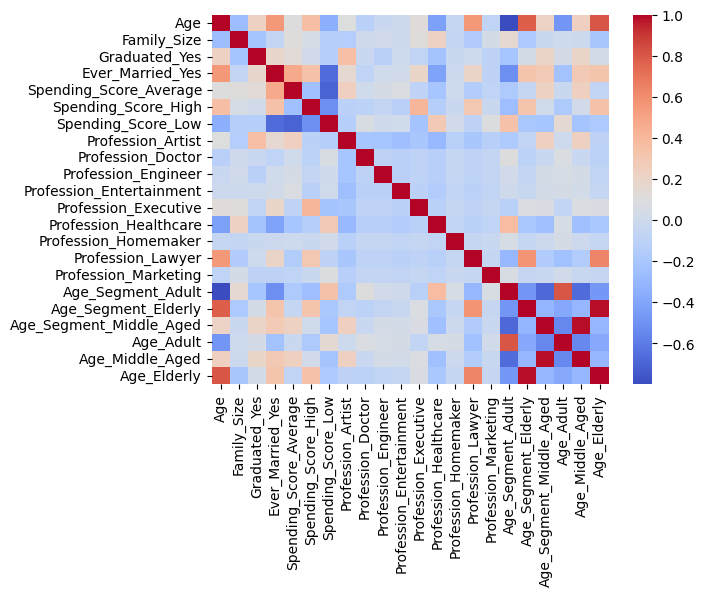

In [75]:
# Compute the correlation matrix
correlation = market_segmentation_interaction.drop(columns=["Segmentation"]).corr()

# Display the correlation on a heatmap
sns.heatmap(correlation, cmap='coolwarm')

Correlation between variables appear relatively low for most pairs. There are a few moderately correlated variables. Interaction terms have higher multicollinearity.

In [76]:
# Save processed dataset
market_segmentation.to_csv("preprocessed_datasets/market_segmentation.csv", index=False)
market_segmentation_interaction.to_csv("preprocessed_datasets/market_segmentation_interaction.csv", index=False)

## 5. Summary

We are aiming to segment potential customers of a car company into four market segments (A, B, C, D) based on their characteristics, using data of previous customers and their segmentations.

For the exploratory data analysis, I looked at the columns of the dataset, their datatypes and the number of null values. I checked that the classes were balanced by producing a count plot of the market segmentation, then balanced the classes to ensure the machine learning model is unbiased.

For each potential explanatory variable, I produced stacked bar charts to analyse the effect of the variable on the segmentation. I dropped insignificant variables. Of interest, I noticed an effect of age group on how age affected the segmentation, so I created a version of the dataset where I added an interaction term between age and age group.

I imputated the missing family size values with the median. To deal with missing values for binary variables, I dropped the rows as there was no effective way to fill in the missing data. I converted the categorical variables into numerical variables with one-hot-encoding. I also normalised the numeric variables to make model fitting easier.

Finally, I visualised the correlation matrix between explanatory variables and found no significantly correlated terms, apart from the interaction terms.

# Regression Model

## 1. Find all variables and understand them

In [28]:
# Load dataset
exam_scores = pd.read_csv("../0. Resources/datasets/exam_scores.csv")
exam_scores.head(10)

,Unnamed: 0,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75
5,5,female,group B,associate's degree,standard,none,married,regularly,yes,1.0,school_bus,5 - 10,73,84,79
6,6,female,group B,some college,standard,completed,widowed,never,no,1.0,private,5 - 10,85,93,89
7,7,male,group B,some college,free/reduced,none,married,sometimes,yes,1.0,private,> 10,41,43,39
8,8,male,group D,high school,free/reduced,completed,single,sometimes,no,3.0,private,> 10,65,64,68
9,9,female,group B,high school,free/reduced,none,married,regularly,yes,NaN,private,< 5,37,59,50


In [29]:
# Drop first column
exam_scores.drop(columns=["Unnamed: 0"], inplace=True)

In [30]:
# Get column types and count of non-null values in each column
exam_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 3.3+ MB


In [31]:
# Summary statistics of numerical variables
exam_scores.describe()

,NrSiblings,MathScore,ReadingScore,WritingScore
count,29069.000000,30641.000000,30641.000000,30641.000000
mean,2.145894,66.558402,69.377533,68.418622
std,1.458242,15.361616,14.758952,15.443525
min,0.000000,0.000000,10.000000,4.000000
25%,1.000000,56.000000,59.000000,58.000000
50%,2.000000,67.000000,70.000000,69.000000
75%,3.000000,78.000000,80.000000,79.000000
max,7.000000,100.000000,100.000000,100.000000


## 2. Visualise data

In [32]:
def plot_boxplot_and_countplot(data, x, y="MathScore"):
    fig, (ax1, ax2) = plt.subplots(ncols=2)

    sns.boxplot(data, x=x, y=y, ax=ax1)
    sns.countplot(data=exam_scores, x=x, ax=ax2)

    fig.set_size_inches(12, 5)

### Gender

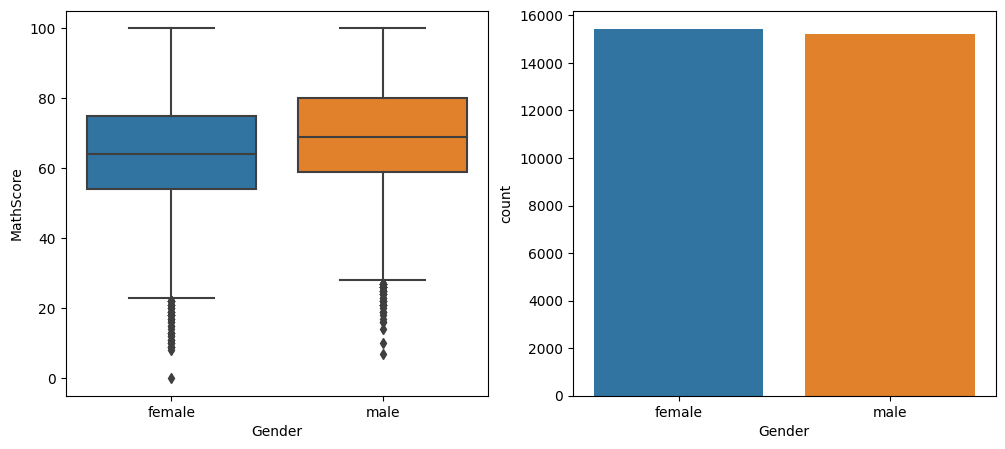

In [33]:
plot_boxplot_and_countplot(exam_scores, "Gender")

Male students appear to have a higher math score on average than female students. Both genders are balanced.

### Ethnic Group

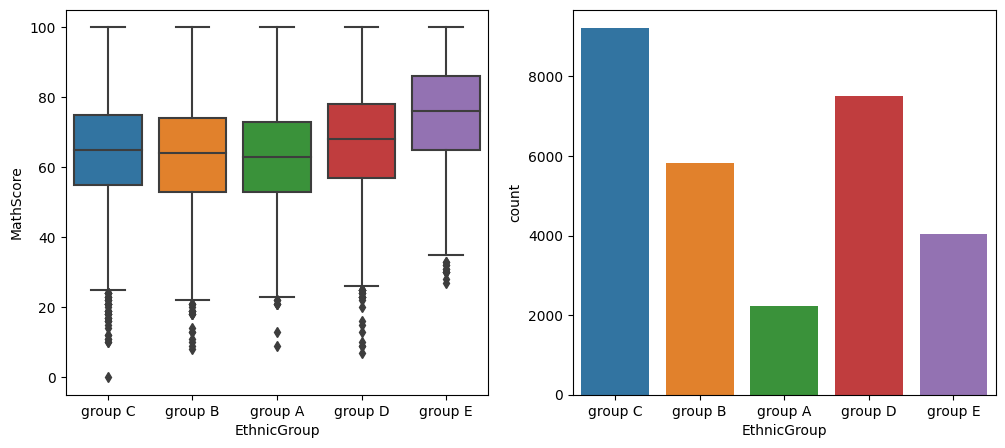

In [34]:
plot_boxplot_and_countplot(exam_scores, "EthnicGroup")

Group E appears to have a higher math score on average than other ethnic groups. There is some imbalance between ethnic groups.

### Parent Education

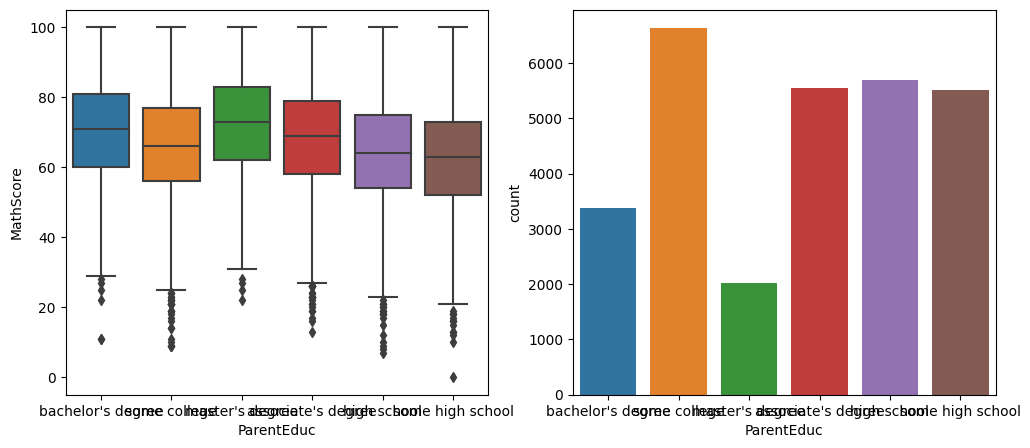

In [35]:
plot_boxplot_and_countplot(exam_scores, "ParentEduc")

The parent's education appears to have an effect on the student's math score.

### Lunch Type

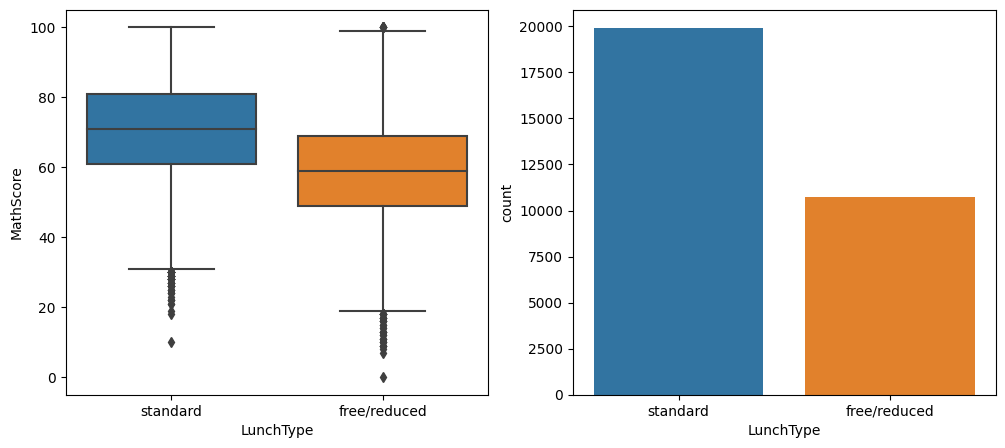

In [36]:
plot_boxplot_and_countplot(exam_scores, "LunchType")

Students with standard lunches appear to have higher math scores on average than those with free/reduced lunches.

### Test Prep

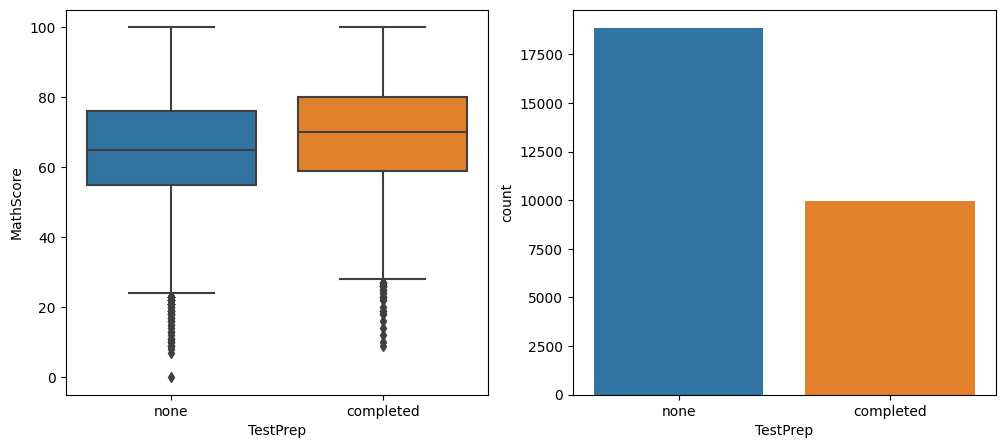

In [37]:
plot_boxplot_and_countplot(exam_scores, "TestPrep")

Students who have completed test prepration appear to have higher math scores on average than those who haven't.

### Parent Marital Status

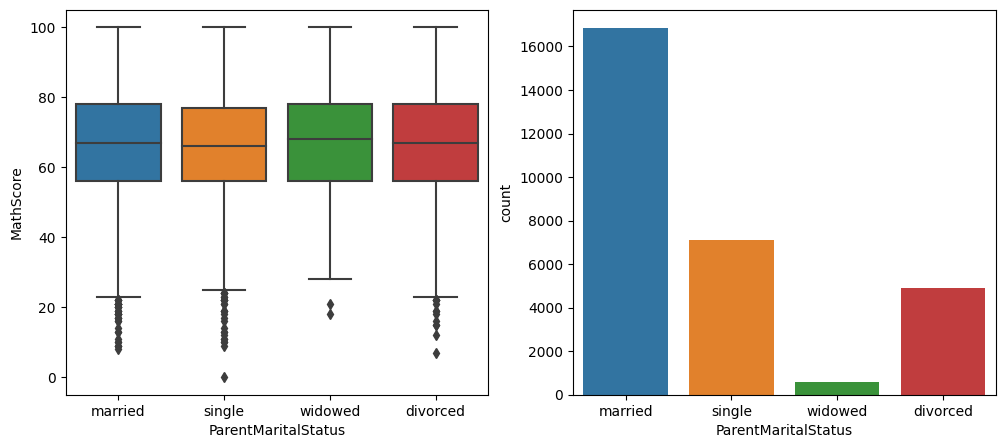

In [38]:
plot_boxplot_and_countplot(exam_scores, "ParentMaritalStatus")

The parent's marital status appears to have no significant effect on the student's math score. Therefore, we drop this feature.

### Practice Sport

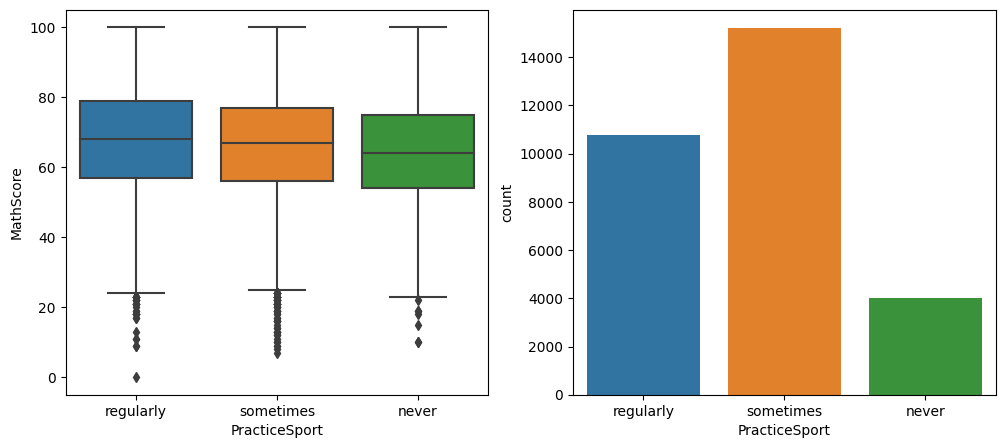

In [39]:
plot_boxplot_and_countplot(exam_scores, "PracticeSport")

Whether the student practises sport appears to have little effect on their math score. Therefore, we drop this feature.

### Number of Siblings

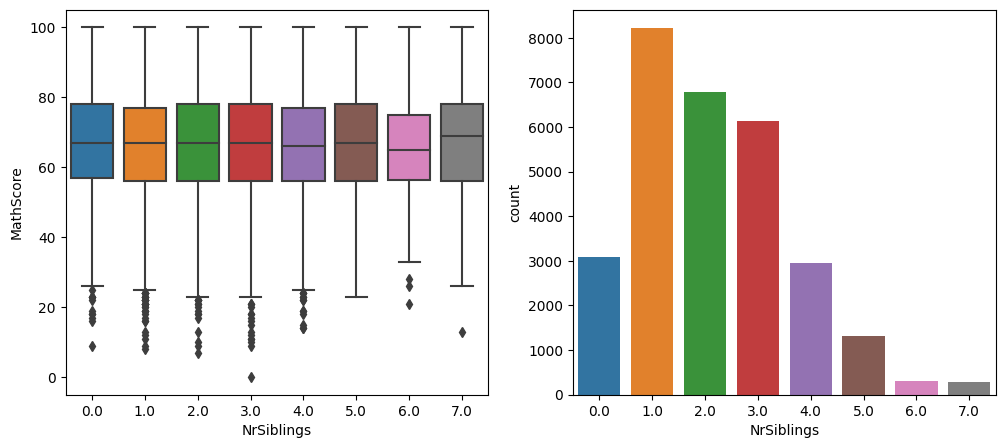

In [40]:
plot_boxplot_and_countplot(exam_scores, "NrSiblings")

The number of siblings a student has appears to have no effect on their math score. Therefore, we drop this feature.

### Is First Child

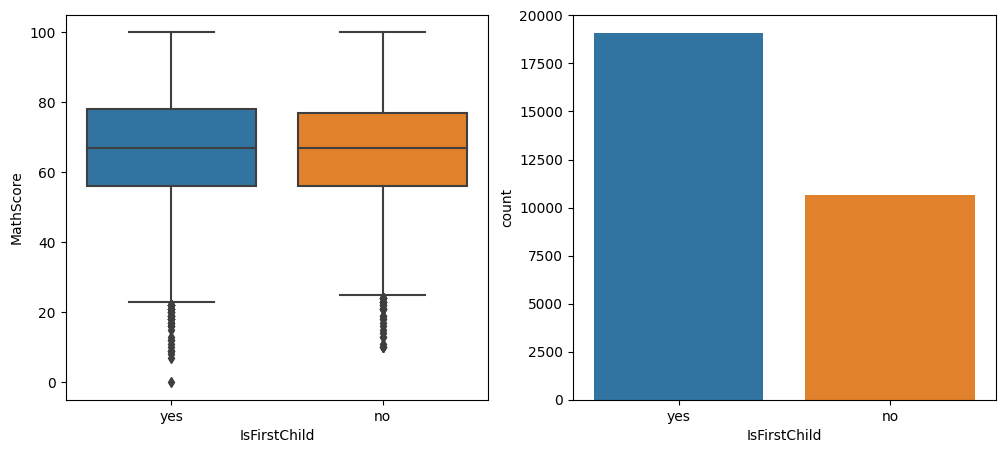

In [41]:
plot_boxplot_and_countplot(exam_scores, "IsFirstChild")

Whether the student is a first child appears to have no effect on their math score. Therefore, we drop this feature.

### Weekly Study Hours

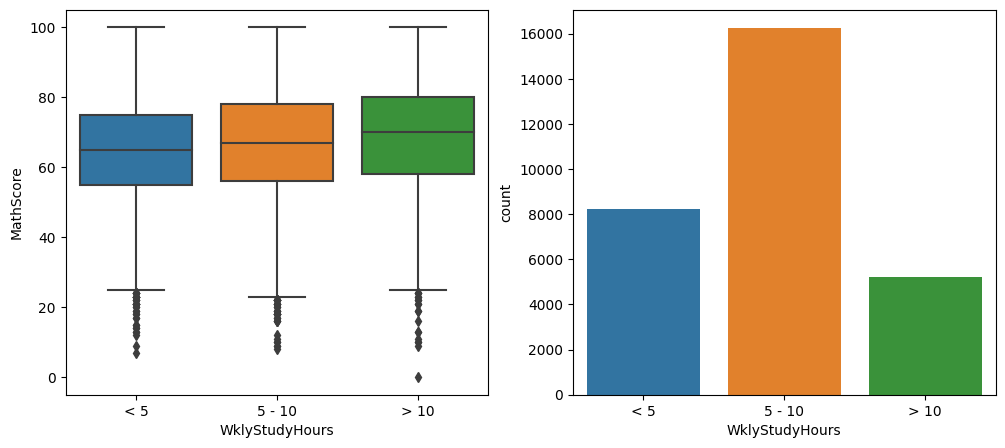

In [42]:
plot_boxplot_and_countplot(exam_scores, "WklyStudyHours")

Students who study more per week tend to have higher math scores on average.

### Transport Means

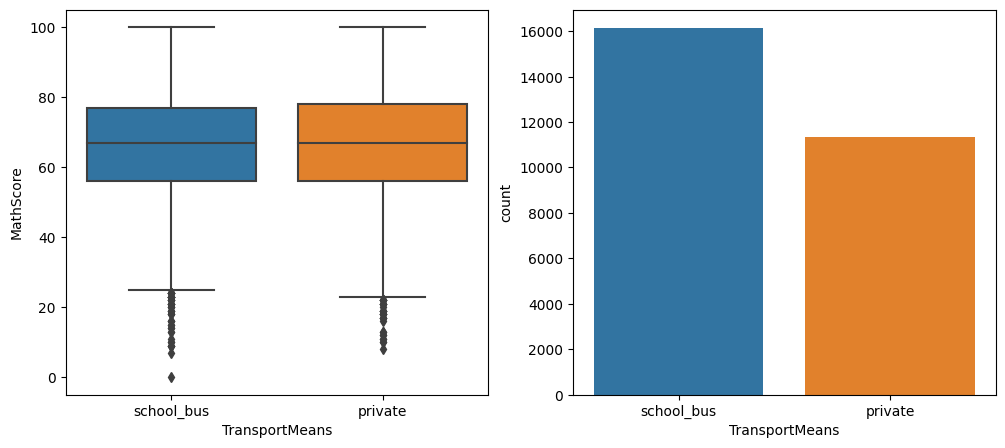

In [43]:
plot_boxplot_and_countplot(exam_scores, "TransportMeans")

The student's transport means appears to have no effect on their math score. Therefore, we drop this feature.

## 3. Clean data

In [44]:
# Drop unnecessary columns
exam_scores.drop(columns=["ParentMaritalStatus", "NrSiblings", "IsFirstChild", "PracticeSport", "TransportMeans"], inplace=True)

In [45]:
# Remove rows with null values
exam_scores.dropna(subset=["WklyStudyHours", "TestPrep"], inplace=True)

In [46]:
# Convert columns with two categories into binary numeric values
exam_scores = pd.get_dummies(exam_scores, columns=["LunchType", "TestPrep", "Gender"], drop_first=True, dtype=int)

In [47]:
# Convert columns with ordered categories into numeric values
exam_scores.WklyStudyHours.replace(["< 5", "5 - 10", "> 10"], [0, 1, 2], inplace=True)

In [48]:
# Convert columns with 3+ categories into numerical values with one-hot encoding
exam_scores = pd.get_dummies(exam_scores, columns=["ParentEduc", "EthnicGroup"], dtype=int)

In [49]:
exam_scores.head()

,WklyStudyHours,MathScore,ReadingScore,WritingScore,LunchType_standard,TestPrep_none,Gender_male,ParentEduc_associate's degree,ParentEduc_bachelor's degree,ParentEduc_high school,ParentEduc_master's degree,ParentEduc_some college,ParentEduc_some high school,EthnicGroup_group A,EthnicGroup_group B,EthnicGroup_group C,EthnicGroup_group D,EthnicGroup_group E
0,0,71,71,74,1,1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,87,93,91,1,1,0,0,0,0,1,0,0,0,1,0,0,0
3,1,45,56,42,0,1,1,1,0,0,0,0,0,1,0,0,0,0
4,1,76,78,75,1,1,1,0,0,0,0,1,0,0,0,1,0,0
5,1,73,84,79,1,1,0,1,0,0,0,0,0,0,1,0,0,0


## 4. Identify correlated variables

<Axes: >

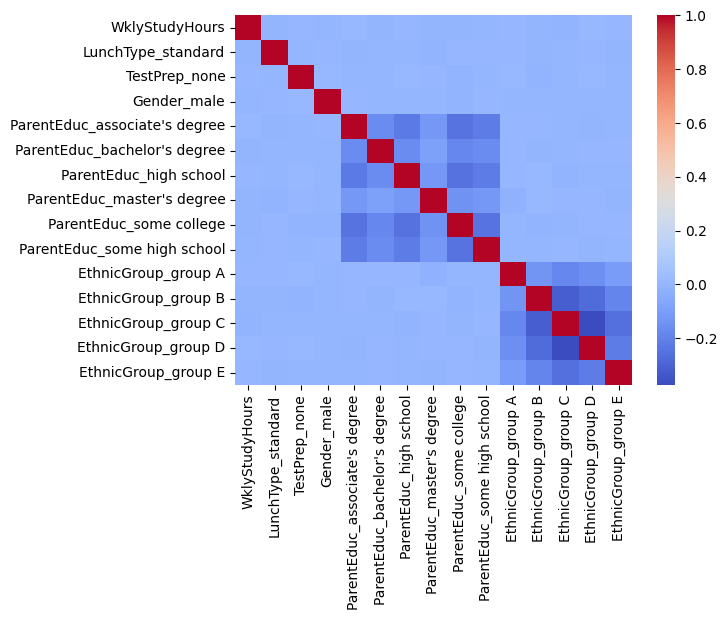

In [50]:
# Compute the correlation matrix
correlation = exam_scores.drop(columns=["MathScore", "ReadingScore", "WritingScore"]).corr()

# Display the correlation on a heatmap
sns.heatmap(correlation, cmap='coolwarm')

There appears to be relatively low correlation between variables. Parent education terms and ethnic group terms have comparatively greater correlation but not to a problematic degree.

In [51]:
# Save processed dataset
exam_scores.to_csv("preprocessed_datasets/exam_scores.csv", index=False)

## 5. Summary

We are aiming to predict the math score of a student, using data of exam scores of public students and a variety of personal and socio-economic factors.

For the exploratory data analysis, I inspected the columns of the dataset, their datatypes and the number of null values. I also created numerical summaries of the data.

For each potential explanatory variable, I produced grouped boxplots to analyse the effect of the variable on the math score. I dropped insignificant variables from the dataset.

To deal with missing values for categorical variables, I dropped the rows with missing values as there was no effective way to fill in the missing data. I applied ordinal encoding for the Weekly Study Hours category as the categories are ordered. I converted the other categorical variables into numeric variables via one-hot-encoding.

Finally, I visualised the correlation matrix between explanatory variables and found no significantly correlated terms.